## Problem 2: Customized Multi-View Dataset

In [1]:
import random
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [2]:
# Reproducibility
SEED = 7
random.seed(SEED)
torch.manual_seed(SEED)


In [3]:
def get_augment_pipeline():
    return transforms.Compose([
        transforms.RandomResizedCrop(size=28, scale=(0.80, 1.00)),
        transforms.RandomAffine(degrees=15, translate=(0.10, 0.10), shear=10),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.20, scale=(0.02, 0.20), ratio=(0.3, 3.3), inplace=True),
    ])

base_transform = transforms.ToTensor()
augment_transform = get_augment_pipeline()

In [4]:
class MNISTTwoView(Dataset):
    """
    Wrap a base dataset (returns PIL image, label) and produce:
      x0: original tensorized image
      x1, x2: two independently augmented views using the SAME pipeline
      y: label
    """
    def __init__(self, base_dataset, base_transform=None, augment_transform=None):
        self.base = base_dataset
        self.base_transform = base_transform
        self.augment_transform = augment_transform
        self._to_pil = transforms.ToPILImage()

    def __len__(self):
        return len(self.base)

    def _ensure_pil(self, img):
        # If the base dataset returns a tensor, convert to PIL for torchvision transforms
        if isinstance(img, Image.Image):
            return img
        return self._to_pil(img)  # tensor (C,H,W) -> PIL

    def __getitem__(self, idx):
        img, y = self.base[idx]
        img = self._ensure_pil(img)

        # Original (no aug besides ToTensor)
        x0 = self.base_transform(img) if self.base_transform else transforms.ToTensor()(img)

        # Two independent augmentations using the SAME pipeline
        x1 = self.augment_transform(img) if self.augment_transform else x0
        x2 = self.augment_transform(img) if self.augment_transform else x0

        return x0, x1, x2, y


In [ ]:
data_root = Path("./data")
data_root.mkdir(parents=True, exist_ok=True)

# Real MNIST
train_base = torchvision.datasets.MNIST(root=str(data_root), train=True, download=True)

train_ds = MNISTTwoView(
    base_dataset=train_base,
    base_transform=base_transform,
    augment_transform=augment_transform
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:03<00:00, 2968105.72it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 522154.62it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1442657.91it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2943985.28it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



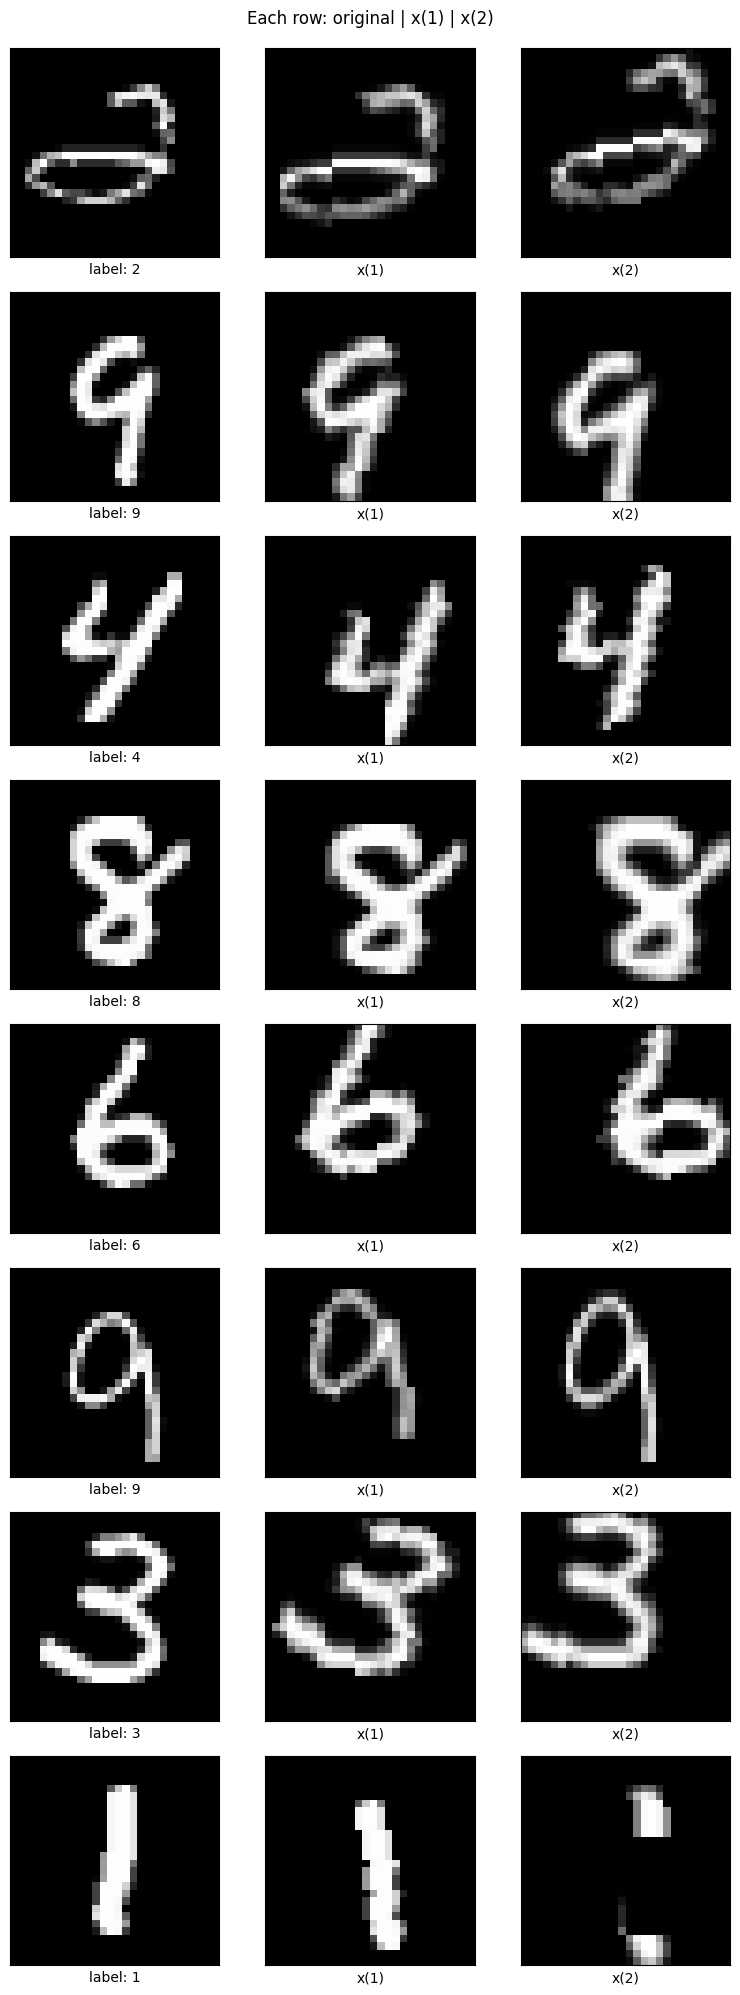

In [6]:
# Fetch one minibatch
x0, x1, x2, y = next(iter(train_loader))  # shapes: (8, 1, 28, 28)
B = x0.shape[0]
assert B == 8, f"Expected batch_size=8, got {B}"

fig, axes = plt.subplots(nrows=B, ncols=3, figsize=(8, 2.5*B))
fig.suptitle("Each row: original | x(1) | x(2)", y=0.995)

for i in range(B):
    # Column 0: original + label under it
    axes[i, 0].imshow(x0[i, 0].cpu().numpy(), cmap="gray")
    axes[i, 0].set_xticks([]); axes[i, 0].set_yticks([])
    axes[i, 0].set_xlabel(f"label: {int(y[i])}")

    # Column 1: x(1)
    axes[i, 1].imshow(x1[i, 0].cpu().numpy(), cmap="gray")
    axes[i, 1].set_xticks([]); axes[i, 1].set_yticks([])
    axes[i, 1].set_xlabel("x(1)")

    # Column 2: x(2)
    axes[i, 2].imshow(x2[i, 0].cpu().numpy(), cmap="gray")
    axes[i, 2].set_xticks([]); axes[i, 2].set_yticks([])
    axes[i, 2].set_xlabel("x(2)")

plt.tight_layout()
plt.show()
